In [1]:
# Plotting imports
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white')

In [2]:
# Other imports
import os
import pandas as pd
import numpy as np
from Bio import Phylo

parSNP tree
-------------

**warning: based on 10% of the reference genome**

In [3]:
t = Phylo.read('../tout/output/parsnp.tree', 'newick')

In [4]:
# Max distance to create better plots
mdist = max([t.distance(t.root, x) for x in t.get_terminals()])

In [5]:
# Where is K12?
for c, i in zip(t.get_terminals(), range(len(list(t.get_terminals())))):
    if c.name == 'genome.fasta.ref':
        eref = i

In [6]:
# Which genomes are really distant? (outgroups)
dists = {x.name:t.distance(t.root, x) for x in t.get_terminals()}
for x in sorted(dists, key=lambda x: dists[x])[::-1][:7]:
    print(x.replace('.fasta', ''))

NT12444_0
NT12445_1
NT12462_213
NT12449_33
NT12461_14
NT12456_190
NT12455_80


In [7]:
outgroups = set()
for l in open('../outgroups.txt'):
    outgroups.add(l.strip())

**Tree with outgroups removed**

In [8]:
t2 = Phylo.read('../tout/output_restricted/parsnp.tree', 'newick')

In [9]:
# Max distance to create better plots
mdist2 = max([t2.distance(t2.root, x) for x in t2.get_terminals()])

In [10]:
# Where is K12?
for c, i in zip(t2.get_terminals(), range(len(list(t2.get_terminals())))):
    if c.name == 'genome.fasta.ref':
        eref2 = i

LS-BSR
-------

**Note:** based on all available genomes

In [11]:
ls_bsr = pd.read_table('../lall/bsr_matrix_values.txt')

In [12]:
ls_bsr.rename(columns={ls_bsr.columns[0]:'Gene'}, inplace=True)
ls_bsr.set_index('Gene', inplace=True)

In [13]:
idx = ls_bsr.sum(axis=1).order(ascending=False).index
ls_bsr_sorted = ls_bsr.ix[idx]

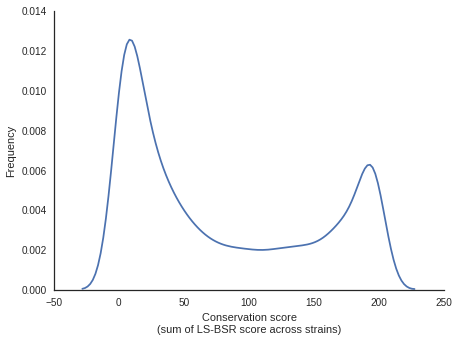

In [14]:
plt.figure(figsize=(7, 5))

sns.kdeplot(ls_bsr.sum(axis=1))

plt.xlabel('Conservation score\n(sum of LS-BSR score across strains)')
plt.ylabel('Frequency')

sns.despine()

In [15]:
ls_bsr_sorted = ls_bsr_sorted[[x.name.replace('.fasta.ref', '').replace('.fasta', '')
                               for x in t.get_terminals()]]

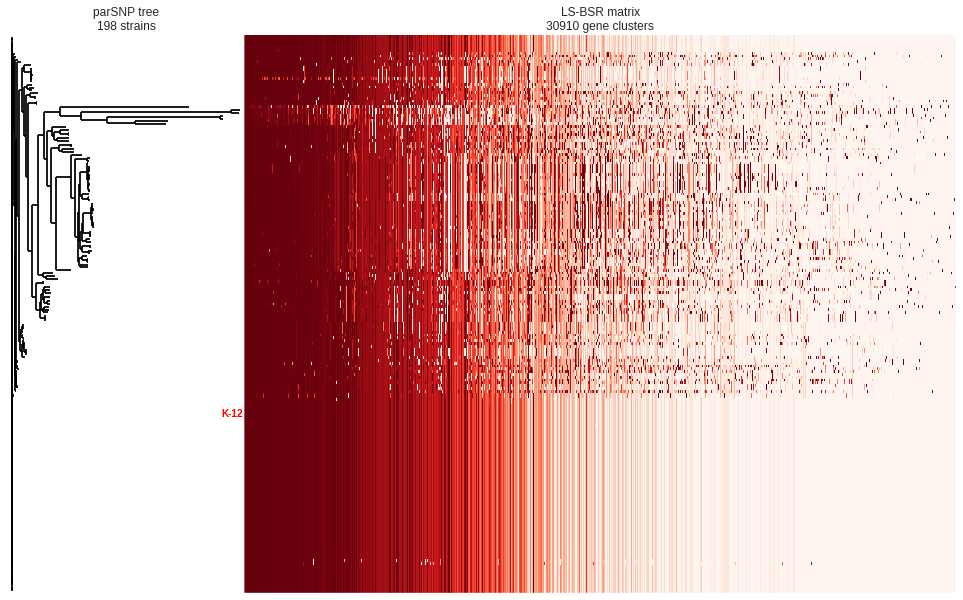

In [16]:
with sns.axes_style('whitegrid'):
    fig = plt.figure(figsize=(17, 10))

    ax1=plt.subplot2grid((1,40), (0, 10), colspan=30)
    a=ax1.imshow(ls_bsr_sorted.T, cmap=plt.cm.Reds,
               vmin=0, vmax=1,
               aspect='auto', interpolation='none')
    ax1.set_yticks([])
    ax1.set_xticks([])
    ax1.axis('off')

    # for x, y, e in [(len(core)/3, len(data[:,0])+1, 'Core'),
    #                 (len(core)+len(softcore)/5, len(data[:,0])+1, 'Soft-core'),
    #                 (len(core)+len(softcore)+len(shell)/2, len(data[:,0])+1, 'Shell'),
    #                 (len(core)+len(softcore)+len(shell)+len(cloud)/2, len(data[:,0])+1, 'Cloud'),]:
    #     text(x, y, e)

    # a=vlines([len(core), len(core)+len(softcore), len(core)+len(softcore)+len(shell),],
    #        0, len(data[:,0])-1, lw=2, color='b')
    # a=hlines(np.arange(0.5, len(orgs), 1), 0, len(core)+len(softcore)+len(shell)+len(cloud),
    #          color='w', lw=.5)


    ax = fig.add_subplot(1,2,1)
    ax=plt.subplot2grid((1,40), (0, 0), colspan=10, axisbg='white')

    fig.subplots_adjust(wspace=0, hspace=0)

    ax1.set_title('LS-BSR matrix\n%d gene clusters'%ls_bsr.shape[0])

    Phylo.draw(t, axes=ax, 
               show_confidence=False,
               label_func=lambda x: None,
               xticks=([],), yticks=([],),
               ylabel=('',), xlabel=('',),
               xlim=(-0.01,mdist+0.01),
               axis=('off',),
               title=('parSNP tree\n%d strains'%ls_bsr.shape[1],), 
               text=((mdist-0.04, eref+0.25, 'K-12'),
                      {'color':'r', 'fontsize':10, 'weight':'bold'}),
              )

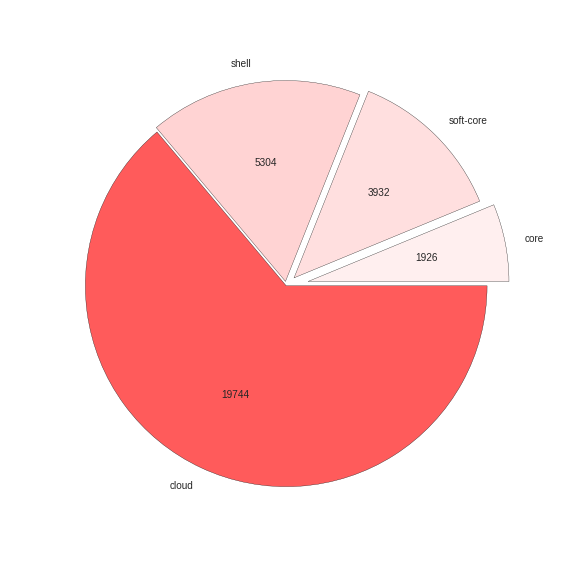

In [17]:
plt.figure(figsize=(10, 10))

pangenome = ls_bsr[ls_bsr > 0.8]
pangenome[np.isnan(pangenome)] = 0
pangenome[pangenome > 0] = 1

core = pangenome[pangenome.sum(axis=1) == pangenome.shape[1]].shape[0]
softcore = pangenome[(pangenome.sum(axis=1) < pangenome.shape[1]) &
                 (pangenome.sum(axis=1) >= pangenome.shape[1]*0.95)].shape[0]
shell = pangenome[(pangenome.sum(axis=1) < pangenome.shape[1]*0.95) &
                 (pangenome.sum(axis=1) >= pangenome.shape[1]*0.15)].shape[0]
cloud = pangenome[pangenome.sum(axis=1) < pangenome.shape[1]*0.15].shape[0]

total = pangenome.shape[0]

def my_autopct(pct):
    val=int(pct*total/100.0)
    return '{v:d}'.format(v=val)

a=plt.pie([core, softcore, shell, cloud], labels=['core', 'soft-core', 'shell', 'cloud'],
      explode=[0.1, 0.05, 0.02, 0], radius=0.9,
      colors=[(1, 0, 0, float(x)/total) for x in (core, softcore, shell, cloud)],
      autopct=my_autopct)

**Outgroups removed**

In [18]:
ls_bsr.drop(list(outgroups),
            axis=1, inplace=True)
ls_bsr.drop(list(ls_bsr[ls_bsr.sum(axis=1) == 0].index),
           inplace=True)

In [19]:
idx = ls_bsr.sum(axis=1).order(ascending=False).index
ls_bsr_sorted = ls_bsr.ix[idx]

In [20]:
ls_bsr_sorted = ls_bsr_sorted[[x.name.replace('.fasta.ref', '').replace('.fasta', '')
                               for x in t2.get_terminals()]]

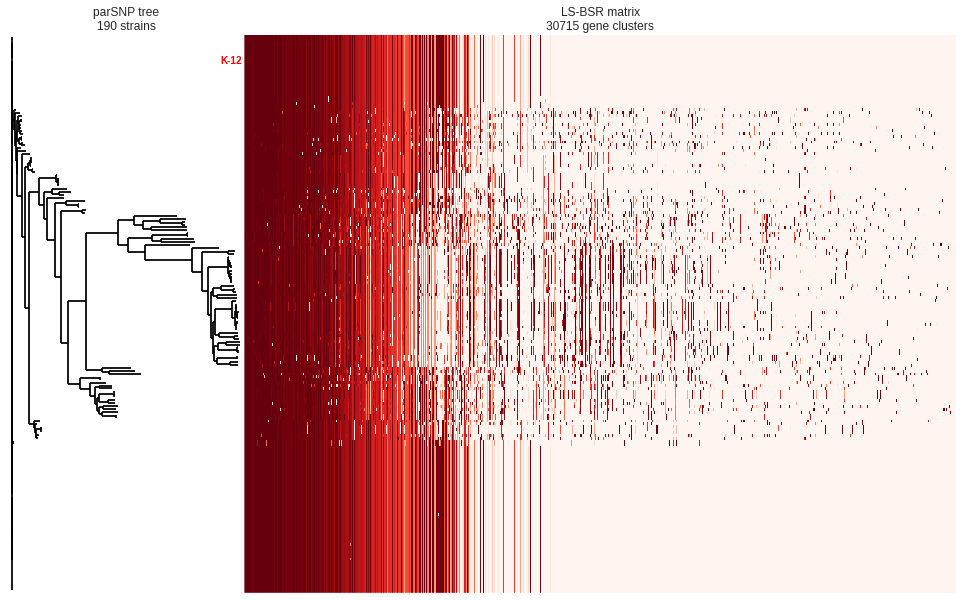

In [21]:
with sns.axes_style('whitegrid'):
    fig = plt.figure(figsize=(17, 10))

    ax1=plt.subplot2grid((1,40), (0, 10), colspan=30)
    a=ax1.imshow(ls_bsr_sorted.T, cmap=plt.cm.Reds,
               vmin=0.6, vmax=1,
               aspect='auto', interpolation='none')
    ax1.set_yticks([])
    ax1.set_xticks([])
    ax1.axis('off')

    # for x, y, e in [(len(core)/3, len(data[:,0])+1, 'Core'),
    #                 (len(core)+len(softcore)/5, len(data[:,0])+1, 'Soft-core'),
    #                 (len(core)+len(softcore)+len(shell)/2, len(data[:,0])+1, 'Shell'),
    #                 (len(core)+len(softcore)+len(shell)+len(cloud)/2, len(data[:,0])+1, 'Cloud'),]:
    #     text(x, y, e)

    # a=vlines([len(core), len(core)+len(softcore), len(core)+len(softcore)+len(shell),],
    #        0, len(data[:,0])-1, lw=2, color='b')
    # a=hlines(np.arange(0.5, len(orgs), 1), 0, len(core)+len(softcore)+len(shell)+len(cloud),
    #          color='w', lw=.5)


    ax = fig.add_subplot(1,2,1)
    ax=plt.subplot2grid((1,40), (0, 0), colspan=10, axisbg='white')

    fig.subplots_adjust(wspace=0, hspace=0)

    ax1.set_title('LS-BSR matrix\n%d gene clusters'%ls_bsr.shape[0])

    Phylo.draw(t2, axes=ax, 
               show_confidence=False,
               label_func=lambda x: None,
               xticks=([],), yticks=([],),
               ylabel=('',), xlabel=('',),
               xlim=(-0.01,mdist2+0.01),
               axis=('off',),
               title=('parSNP tree\n%d strains'%ls_bsr.shape[1],), 
               text=((mdist2-0.04, eref2+1, 'K-12'),
                      {'color':'r', 'fontsize':10, 'weight':'bold'}),
              )

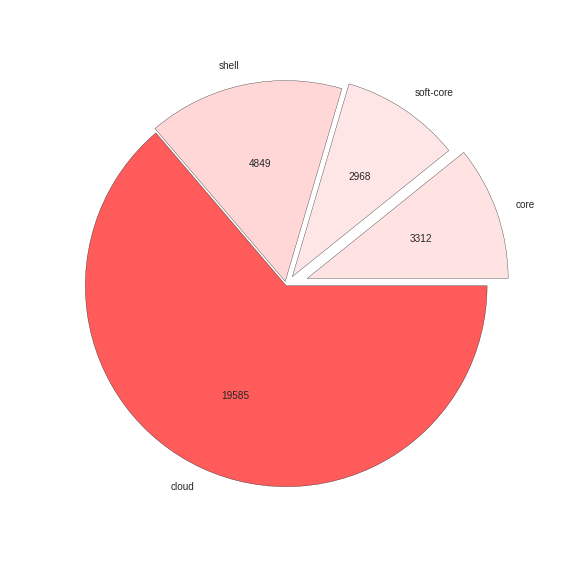

In [22]:
plt.figure(figsize=(10, 10))

pangenome = ls_bsr[ls_bsr > 0.8]
pangenome[np.isnan(pangenome)] = 0
pangenome[pangenome > 0] = 1

core = pangenome[pangenome.sum(axis=1) == pangenome.shape[1]].shape[0]
softcore = pangenome[(pangenome.sum(axis=1) < pangenome.shape[1]) &
                 (pangenome.sum(axis=1) >= pangenome.shape[1]*0.95)].shape[0]
shell = pangenome[(pangenome.sum(axis=1) < pangenome.shape[1]*0.95) &
                 (pangenome.sum(axis=1) >= pangenome.shape[1]*0.15)].shape[0]
cloud = pangenome[pangenome.sum(axis=1) < pangenome.shape[1]*0.15].shape[0]

total = pangenome.shape[0]

def my_autopct(pct):
    val=int(pct*total/100.0)
    return '{v:d}'.format(v=val)

a=plt.pie([core, softcore, shell, cloud], labels=['core', 'soft-core', 'shell', 'cloud'],
      explode=[0.1, 0.05, 0.02, 0], radius=0.9,
      colors=[(1, 0, 0, float(x)/total) for x in (core, softcore, shell, cloud)],
      autopct=my_autopct)

LS-BSR
-------

**Note:** based on the K-12 proteome only

In [23]:
ls_bsr = pd.read_table('../lreference/bsr_matrix_values.txt')

In [24]:
ls_bsr.rename(columns={ls_bsr.columns[0]:'Gene'}, inplace=True)
ls_bsr.set_index('Gene', inplace=True)

In [25]:
idx = ls_bsr.sum(axis=1).order(ascending=False).index
ls_bsr_sorted = ls_bsr.ix[idx]

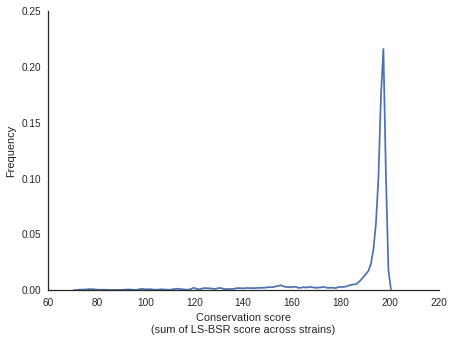

In [26]:
plt.figure(figsize=(7, 5))

sns.kdeplot(ls_bsr.sum(axis=1))

plt.xlabel('Conservation score\n(sum of LS-BSR score across strains)')
plt.ylabel('Frequency')

sns.despine()

In [27]:
ls_bsr_sorted = ls_bsr_sorted[[x.name.replace('.fasta.ref', '').replace('.fasta', '')
                               for x in t.get_terminals()]]

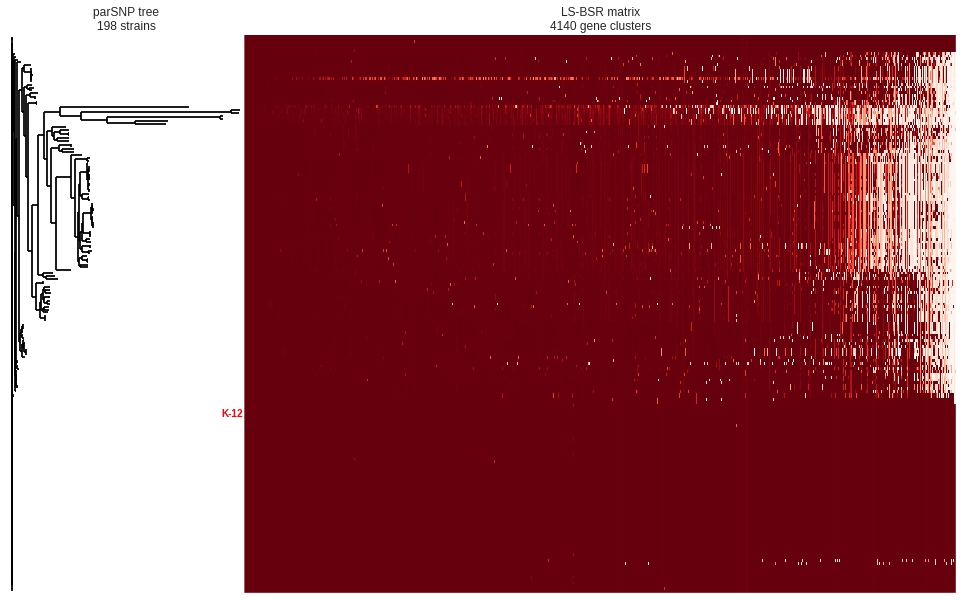

In [28]:
with sns.axes_style('whitegrid'):
    fig = plt.figure(figsize=(17, 10))

    ax1=plt.subplot2grid((1,40), (0, 10), colspan=30)
    a=ax1.imshow(ls_bsr_sorted.T, cmap=plt.cm.Reds,
               vmin=0, vmax=1,
               aspect='auto', interpolation='none')
    ax1.set_yticks([])
    ax1.set_xticks([])
    ax1.axis('off')

    # for x, y, e in [(len(core)/3, len(data[:,0])+1, 'Core'),
    #                 (len(core)+len(softcore)/5, len(data[:,0])+1, 'Soft-core'),
    #                 (len(core)+len(softcore)+len(shell)/2, len(data[:,0])+1, 'Shell'),
    #                 (len(core)+len(softcore)+len(shell)+len(cloud)/2, len(data[:,0])+1, 'Cloud'),]:
    #     text(x, y, e)

    # a=vlines([len(core), len(core)+len(softcore), len(core)+len(softcore)+len(shell),],
    #        0, len(data[:,0])-1, lw=2, color='b')
    # a=hlines(np.arange(0.5, len(orgs), 1), 0, len(core)+len(softcore)+len(shell)+len(cloud),
    #          color='w', lw=.5)


    ax = fig.add_subplot(1,2,1)
    ax=plt.subplot2grid((1,40), (0, 0), colspan=10, axisbg='white')

    fig.subplots_adjust(wspace=0, hspace=0)

    ax1.set_title('LS-BSR matrix\n%d gene clusters'%ls_bsr.shape[0])

    Phylo.draw(t, axes=ax, 
               show_confidence=False,
               label_func=lambda x: None,
               xticks=([],), yticks=([],),
               ylabel=('',), xlabel=('',),
               xlim=(-0.01,mdist+0.01),
               axis=('off',),
               title=('parSNP tree\n%d strains'%ls_bsr.shape[1],), 
               text=((mdist-0.04, eref+0.25, 'K-12'),
                      {'color':'r', 'fontsize':10, 'weight':'bold'}),
              )

**Outgroups removed**

In [29]:
ls_bsr.drop(list(outgroups),
            axis=1, inplace=True)
ls_bsr.drop(list(ls_bsr[ls_bsr.sum(axis=1) == 0].index),
           inplace=True)

In [30]:
idx = ls_bsr.sum(axis=1).order(ascending=False).index
ls_bsr_sorted = ls_bsr.ix[idx]

In [31]:
ls_bsr_sorted = ls_bsr_sorted[[x.name.replace('.fasta.ref', '').replace('.fasta', '')
                               for x in t2.get_terminals()]]

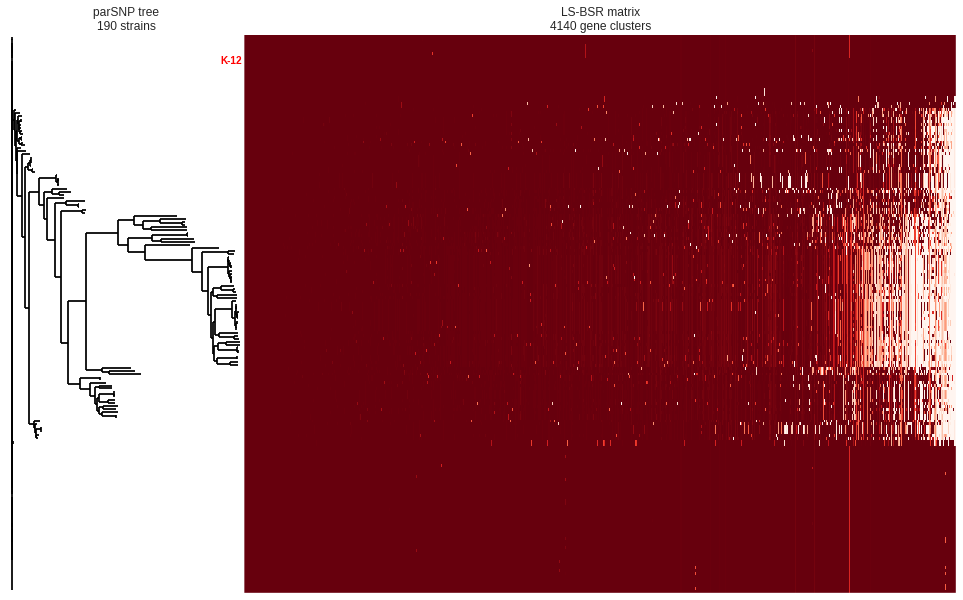

In [32]:
with sns.axes_style('whitegrid'):
    fig = plt.figure(figsize=(17, 10))

    ax1=plt.subplot2grid((1,40), (0, 10), colspan=30)
    a=ax1.imshow(ls_bsr_sorted.T, cmap=plt.cm.Reds,
               vmin=0, vmax=1,
               aspect='auto', interpolation='none')
    ax1.set_yticks([])
    ax1.set_xticks([])
    ax1.axis('off')

    # for x, y, e in [(len(core)/3, len(data[:,0])+1, 'Core'),
    #                 (len(core)+len(softcore)/5, len(data[:,0])+1, 'Soft-core'),
    #                 (len(core)+len(softcore)+len(shell)/2, len(data[:,0])+1, 'Shell'),
    #                 (len(core)+len(softcore)+len(shell)+len(cloud)/2, len(data[:,0])+1, 'Cloud'),]:
    #     text(x, y, e)

    # a=vlines([len(core), len(core)+len(softcore), len(core)+len(softcore)+len(shell),],
    #        0, len(data[:,0])-1, lw=2, color='b')
    # a=hlines(np.arange(0.5, len(orgs), 1), 0, len(core)+len(softcore)+len(shell)+len(cloud),
    #          color='w', lw=.5)


    ax = fig.add_subplot(1,2,1)
    ax=plt.subplot2grid((1,40), (0, 0), colspan=10, axisbg='white')

    fig.subplots_adjust(wspace=0, hspace=0)

    ax1.set_title('LS-BSR matrix\n%d gene clusters'%ls_bsr.shape[0])

    Phylo.draw(t2, axes=ax, 
               show_confidence=False,
               label_func=lambda x: None,
               xticks=([],), yticks=([],),
               ylabel=('',), xlabel=('',),
               xlim=(-0.01,mdist2+0.01),
               axis=('off',),
               title=('parSNP tree\n%d strains'%ls_bsr.shape[1],), 
               text=((mdist2-0.04, eref2+1, 'K-12'),
                      {'color':'r', 'fontsize':10, 'weight':'bold'}),
              )

Roary
------

In [29]:
roary = pd.read_table('../roary/gene_presence_absence.csv',
                     sep=',',
                     low_memory=False)
roary.set_index('Gene', inplace=True)
roary.drop(list(roary.columns[:10]), axis=1, inplace=True)

In [30]:
roary.replace('.{2,100}', 1, regex=True, inplace=True)
roary.replace(np.nan, 0, regex=True, inplace=True)

In [31]:
idx = roary.sum(axis=1).order(ascending=False).index
roary_sorted = roary.ix[idx]

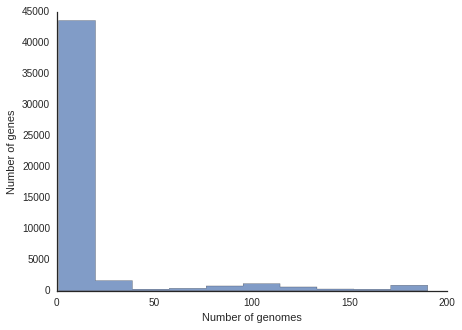

In [32]:
plt.figure(figsize=(7, 5))

plt.hist(roary.sum(axis=1), 10, histtype="stepfilled", alpha=.7)

plt.xlabel('Number of genomes')
plt.ylabel('Number of genes')

sns.despine()

In [33]:
for c, i in zip(t2.get_terminals(), range(len(list(t2.get_terminals())))):
    if c.name == 'genome.fasta.ref':
        eref2 = i
roary_sorted = roary_sorted[[x.name.replace('.fasta', '').replace('.ref', '')
                               for x in t2.get_terminals()]]

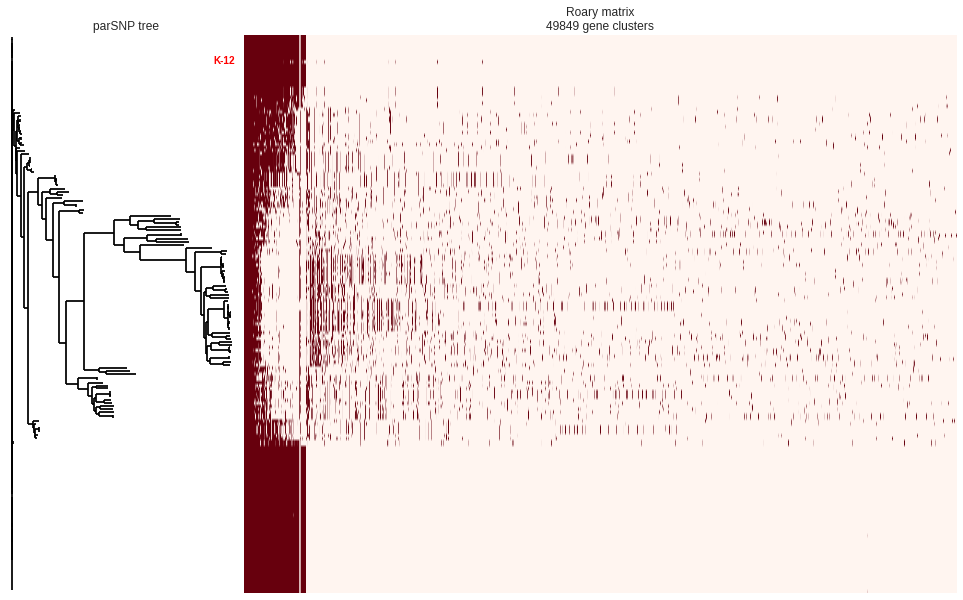

In [34]:
with sns.axes_style('whitegrid'):
    fig = plt.figure(figsize=(17, 10))

    ax1=plt.subplot2grid((1,40), (0, 10), colspan=30)
    a=ax1.imshow(roary_sorted.T, cmap=plt.cm.Reds,
               vmin=0, vmax=1,
               aspect='auto',
               #interpolation='none',
                )
    ax1.set_yticks([])
    ax1.set_xticks([])
    ax1.axis('off')

    # for x, y, e in [(len(core)/3, len(data[:,0])+1, 'Core'),
    #                 (len(core)+len(softcore)/5, len(data[:,0])+1, 'Soft-core'),
    #                 (len(core)+len(softcore)+len(shell)/2, len(data[:,0])+1, 'Shell'),
    #                 (len(core)+len(softcore)+len(shell)+len(cloud)/2, len(data[:,0])+1, 'Cloud'),]:
    #     text(x, y, e)

    # a=vlines([len(core), len(core)+len(softcore), len(core)+len(softcore)+len(shell),],
    #        0, len(data[:,0])-1, lw=2, color='b')
    # a=hlines(np.arange(0.5, len(orgs), 1), 0, len(core)+len(softcore)+len(shell)+len(cloud),
    #          color='w', lw=.5)


    ax = fig.add_subplot(1,2,1)
    ax=plt.subplot2grid((1,40), (0, 0), colspan=10, axisbg='white')

    fig.subplots_adjust(wspace=0, hspace=0)

    ax1.set_title('Roary matrix\n%d gene clusters'%roary.shape[0])

    Phylo.draw(t2, axes=ax, 
               show_confidence=False,
               label_func=lambda x: None,
               xticks=([],), yticks=([],),
               ylabel=('',), xlabel=('',),
               xlim=(-0.01,mdist+0.01),
               axis=('off',),
               title=('parSNP tree',), 
                text=((mdist2-0.04, eref2+1, 'K-12'),
                      {'color':'r', 'fontsize':10, 'weight':'bold'}),
              )

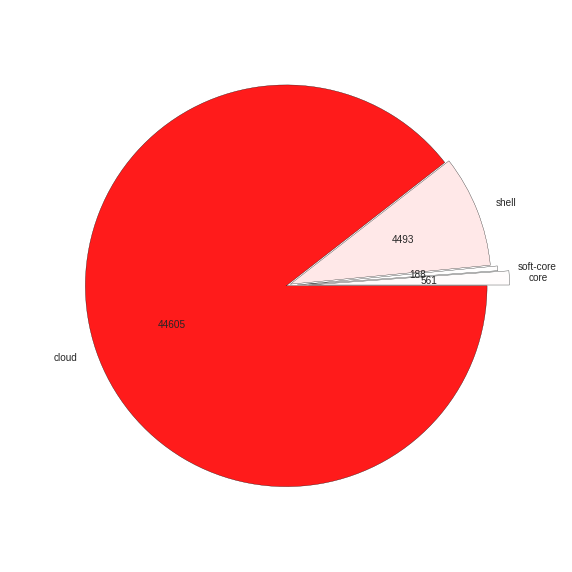

In [35]:
plt.figure(figsize=(10, 10))

core = roary[roary.sum(axis=1) == roary.shape[1]].shape[0]
softcore = roary[(roary.sum(axis=1) < roary.shape[1]) &
                 (roary.sum(axis=1) >= roary.shape[1]*0.95)].shape[0]
shell = roary[(roary.sum(axis=1) < roary.shape[1]*0.95) &
                 (roary.sum(axis=1) >= roary.shape[1]*0.15)].shape[0]
cloud = roary[roary.sum(axis=1) < roary.shape[1]*0.15].shape[0]

total = roary.shape[0]

def my_autopct(pct):
    val=int(pct*total/100.0)
    return '{v:d}'.format(v=val)

a=plt.pie([core, softcore, shell, cloud], labels=['core', 'soft-core', 'shell', 'cloud'],
      explode=[0.1, 0.05, 0.02, 0], radius=0.9,
      colors=[(1, 0, 0, float(x)/total) for x in (core, softcore, shell, cloud)],
      autopct=my_autopct)